# Metalens Data EDA

This notebook explores the real metalens phase profile data located in the `real_data` directory.
We will:
1. Load a sample file.
2. Check its dimensions and statistical properties.
3. Visualize the phase profile.
4. **Efficiently batch verify dimensions for all files.**

In [11]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Uses 'tqdm' for progress bars if installed, but loops work without it too

# Set plot style
plt.style.use('ggplot')

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [12]:
# Configuration
DATA_DIR = "../real_data"
SAMPLE_FILENAME = "Metalens001.csv"
FILE_PATH = os.path.join(DATA_DIR, SAMPLE_FILENAME)

print(f"Analyzing file from: {os.path.abspath(DATA_DIR)}")

Analyzing file from: /Users/sannankanwar/Desktop/FYP/January/real_data


## 1. Load Single Sample
The data is stored in CSV format without headers. We load one file to understand the structure.

In [13]:
try:
    df = pd.read_csv(FILE_PATH, header=None)
    data = df.values
    EXPECTED_SHAPE = data.shape
    print("Data loaded successfully.")
    print(f"Expected Shape based on {SAMPLE_FILENAME}: {EXPECTED_SHAPE}")
except Exception as e:
    print(f"Error loading data: {e}")

Error loading data: [Errno 2] No such file or directory: '../real_data/Metalens001.csv'


## 2. Statistics (Sample)
Basic stats for the first file.

In [14]:
print(f"Min: {np.min(data):.4f}")
print(f"Max: {np.max(data):.4f}")
print(f"Mean: {np.mean(data):.4f}")
print(f"Std: {np.std(data):.4f}")

nans = np.isnan(data).sum()
print(f"NaNs: {nans}")

Min: -3.1416
Max: 3.1416
Mean: -0.0557
Std: 1.7212
NaNs: 0


## 3. Visualization
Plotting the phase profile as a heatmap.

NameError: name 'EXPECTED_SHAPE' is not defined

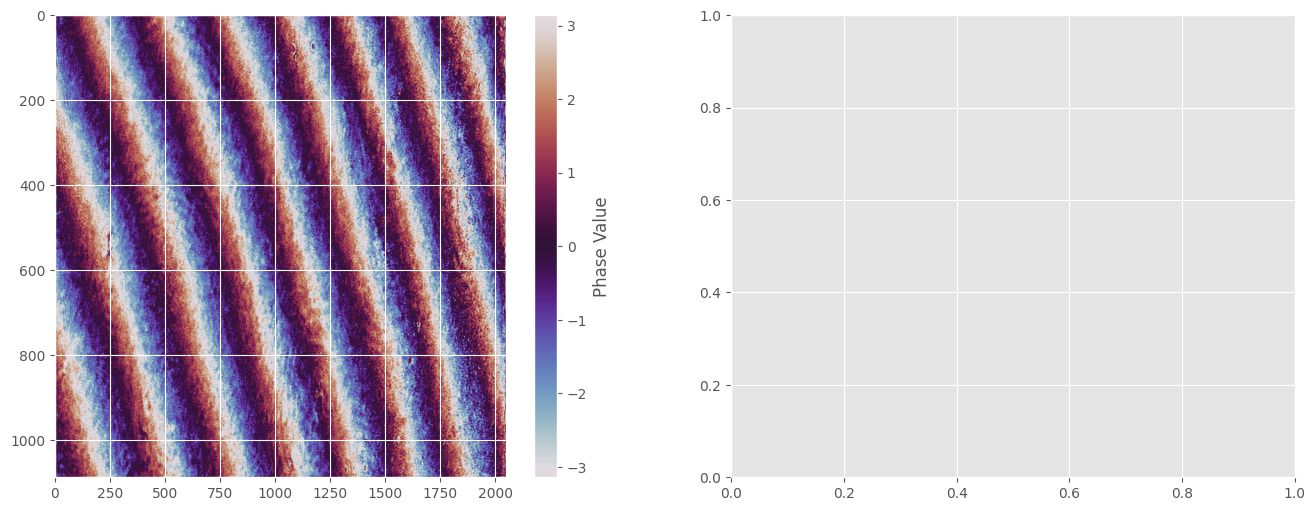

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap
# Use 'twilight' if data looks like wrapped phase [-pi, pi], otherwise 'viridis'
is_wrapped = (np.min(data) >= -np.pi - 0.1) and (np.max(data) <= np.pi + 0.1)
cmap = 'twilight' if is_wrapped else 'viridis'

cax = ax[0].imshow(data, cmap=cmap, aspect='auto', origin='upper')
fig.colorbar(cax, ax=ax[0], label='Phase Value')
ax[0].set_title(f"Phase Profile Heatmap {EXPECTED_SHAPE}")
ax[0].grid(False)

# Histogram
sns.histplot(data.flatten(), bins=100, ax=ax[1], kde=True, color='purple')
ax[1].set_title("Value Distribution")
ax[1].set_xlabel("Phase Value")

plt.tight_layout()
plt.show()

## 4. Efficient Batch Dimension Verification

**Is there a better way?**
Yes! Loading every CSV into pandas is slow (`O(n)` memory and compute) just to check dimensions. 
Instead, we can simply:
1. Read the **first line** to count commas (+1) = number of columns.
2. Count the **newlines** in the file = number of rows.

This avoids parsing floats or allocating memory for the data.

In [ ]:
def get_csv_shape_fast(filepath):
    """
    Efficiently determine CSV shape without loading the whole file.
    """
    with open(filepath, 'r') as f:
        # 1. Get columns from first line
        first_line = f.readline()
        if not first_line:
            return 0, 0
        cols = len(first_line.split(','))
        
        # 2. Count remaining lines (start at 1 because we read one)
        # This creates a generator that counts lines one by one without loading file into RAM
        rows = 1 + sum(1 for _ in f)
        
    return rows, cols

print("Function defined.")

In [ ]:
# Get all files
all_files = sorted(glob.glob(os.path.join(DATA_DIR, "Metalens*.csv")))
print(f"Found {len(all_files)} files to check.")

mismatches = []
valid_count = 0

print(f"Verifying dimensions against expected shape: {EXPECTED_SHAPE}...")

for filepath in all_files:
    filename = os.path.basename(filepath)
    try:
        shape = get_csv_shape_fast(filepath)
        
        if shape == EXPECTED_SHAPE:
            valid_count += 1
        else:
            mismatches.append((filename, shape))
            print(f"[MISMATCH] {filename}: {shape}")
            
    except Exception as e:
        print(f"[ERROR] Could not read {filename}: {e}")

print("-" * 30)
if not mismatches:
    print(f"SUCCESS: All {valid_count} files match dimensions {EXPECTED_SHAPE}")
else:
    print(f"WARNING: Found {len(mismatches)} files with incorrect dimensions!")
    for m in mismatches:
        print(f"  - {m[0]}: {m[1]}")